In [1]:
import os

import numpy as np
import morphsnakes as ms
import pystac
import rasterio
import stac2dcache

from pystac.extensions.eo import EOExtension
from pystac.extensions.projection import ProjectionExtension

from stac2dcache.drivers import get_driver

from eratosthenes.input.read_sentinel2 import read_mean_sun_angles_s2
from eratosthenes.preprocessing.handler_multispec import get_shadow_bands
from eratosthenes.preprocessing.shadow_transforms import apply_shadow_transform
from eratosthenes.preprocessing.shadow_geometry import shadow_image_to_list
from eratosthenes.generic.mapping_io import make_geo_im
from eratosthenes.postprocessing.solar_tools import make_shadowing

In [2]:
import matplotlib.pyplot as plt

# Generate and classify shadow-enhanced images

This notebook showcases how the shadow classification is carried out for an example scene. It requires the catalog where to store the output to be set up (see previous notebook). For the script employed to run the workflow over the full catalog see the [scripts folder](../scripts). 

In [3]:
# input cell
MACAROON_PATH = "./macaroon.dat"

CATALOG_URL = "https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/red-glacier_shadows"
DEM_URL = "https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/CopernicusDEM_tiles_sentinel-2/COP-DEM-05VMG.tif"

BBOX = [490229, 6642656, 516134, 6660489]
SHADOW_TRANSFORM = "entropy"
ANGLE = 138

ITEM_ID = "S2_2022-02-06"

In [4]:
def _read_catalog(url, stac_io=None):
    """
    Read STAC catalog from URL

    :param url: urlpath to the catalog root
    :param stac_io (optional): STAC IO instance to read the catalog
    :return: PyStac Catalog object
    """
    url = url if url.endswith("catalog.json") else f"{url}/catalog.json"
    catalog = pystac.Catalog.from_file(url, stac_io=stac_io)
    return catalog


def _read_remote_file(url, filesystem, **kwargs):
    """
    Read remote file from URL
    
    :param url: urlpath to the file (guess driver from extension)
    :param filesystem: filesystem object where to read the file
    :return: file object
    """
    driver = get_driver(url)
    driver.set_filesystem(filesystem)
    return driver.get(**kwargs)


def _get_bbox_indices(x, y, bbox):
    """
    Convert bbox values to array indices

    :param x, y: arrays with the X, Y coordinates
    :param bbox: minx, miny, maxx, maxy values
    :return: bbox converted to array indices
    """
    minx, miny, maxx, maxy = bbox
    xindices, = np.where((x >= minx) & (x <= maxx))
    yindices, = np.where((y >= miny) & (y <= maxy))
    return xindices[0], xindices[-1]+1, yindices[0], yindices[-1]+1

In [5]:
# configure connection to dCache
stac2dcache.configure(token_filename=MACAROON_PATH)

In [6]:
# read catalog and extract item
catalog = _read_catalog(CATALOG_URL, stac2dcache.stac_io)
item = catalog.get_item(ITEM_ID, recursive=True)
item

<Item id=S2_2022-02-06>

In [7]:
# get bands and granule metadata from L1C item
item_l1c_link = item.get_single_link("item-L1C")
item_l1c = pystac.Item.from_file(
    item_l1c_link.get_absolute_href(), stac_io=stac2dcache.stac_io
)
hrefs = [
    item_l1c.assets[f"B{band:02}"].get_absolute_href() 
    for band in get_shadow_bands("sentinel-2")
]
bands = [
    _read_remote_file(href, stac2dcache.fs, masked=True) for href in hrefs
]
metadata = _read_remote_file(
    item_l1c.assets["granule-metadata"].get_absolute_href(),
    stac2dcache.fs
)

# get scene classification layer from L2A item (if available)
item_l2a_link = item.get_single_link("item-L2A")
if item_l2a_link is not None:
    item_l2a = pystac.Item.from_file(
        item_l2a_link.get_absolute_href(), stac_io=stac2dcache.stac_io,
    )
    scl = _read_remote_file(
        item_l2a.assets["SCL"].get_absolute_href(), 
        stac2dcache.fs,
    )
else:
    scl = None

# get digital elevation model
dem = _read_remote_file(DEM_URL, stac2dcache.fs, masked=True)

In [8]:
# extract bbox indices to crop sun angle matrices
bbox_indices = _get_bbox_indices(bands[0].x, bands[0].y, BBOX) 

# homogenize rasters
bands = [b.rio.slice_xy(*BBOX) for b in bands]
blue, green, red, NIR = [b.squeeze().data for b in bands]

dem = dem.rio.slice_xy(*BBOX)
dem = dem.squeeze().data

if scl is not None:
    # crop and upscale scene classification layer
    scl = scl.rio.reproject_match(
        bands[0], resampling=rasterio.enums.Resampling.nearest
    )
    scl = scl.squeeze().data

# get CRS and transform to write output
crs = bands[0].rio.crs.to_wkt()
epsg = bands[0].rio.crs.to_epsg()
transform = bands[0].rio.transform().to_gdal()
date_created=item.datetime.strftime("%Y:%m:%d %H:%M:%S")
input_parameters = {
    "shadow_transfom": SHADOW_TRANSFORM, 
    "angle": ANGLE,
}

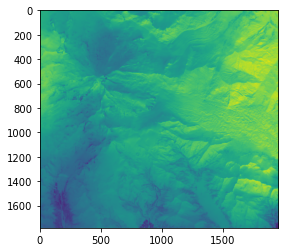

In [9]:
plt.imshow(green)

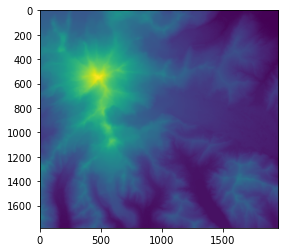

In [10]:
plt.imshow(dem)

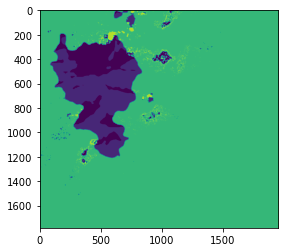

In [11]:
plt.imshow(scl)

In [12]:
work_path = "./"

# write out metadata file, needed by eratosthenes functions
with open(f"{work_path}/MTD_TL.xml", "w") as f:
    f.write(metadata)

# generate shadow-enhanced image 
shadow, albedo = apply_shadow_transform(SHADOW_TRANSFORM, Blue=blue, 
                                        Green=green, Red=red, Near=NIR,
                                        a=ANGLE, RedEdge=None, Shw=None)

# make shadowing image from DEM
(sun_zn, sun_az) = read_mean_sun_angles_s2(work_path)
shadow_artificial = make_shadowing(dem, sun_az, sun_zn)

# get cloud mask from scene classification layer
cloud_mask = scl == 9 if scl is not None else None

# classify shadow-enhanced image
classification = ms.morphological_chan_vese(shadow, 30, 
                                            init_level_set=shadow_artificial,
                                            lambda1=1, lambda2=1, smoothing=0, 
                                            albedo=albedo, mask=cloud_mask)
shadow_image_to_list(classification, transform, work_path, Zn=sun_zn, 
                     Az=sun_az, bbox=bbox_indices)

/tmp/ipykernel_1265775/2931402693.py:20: RankWarning: Polyfit may be poorly conditioned
  classification = ms.morphological_chan_vese(shadow, 30,
/tmp/ipykernel_1265775/2931402693.py:20: RankWarning: Polyfit may be poorly conditioned
  classification = ms.morphological_chan_vese(shadow, 30,
/tmp/ipykernel_1265775/2931402693.py:20: RankWarning: Polyfit may be poorly conditioned
  classification = ms.morphological_chan_vese(shadow, 30,
/tmp/ipykernel_1265775/2931402693.py:20: RankWarning: Polyfit may be poorly conditioned
  classification = ms.morphological_chan_vese(shadow, 30,
/tmp/ipykernel_1265775/2931402693.py:20: RankWarning: Polyfit may be poorly conditioned
  classification = ms.morphological_chan_vese(shadow, 30,
/tmp/ipykernel_1265775/2931402693.py:20: RankWarning: Polyfit may be poorly conditioned
  classification = ms.morphological_chan_vese(shadow, 30,
/tmp/ipykernel_1265775/2931402693.py:20: RankWarning: Polyfit may be poorly conditioned
  classification = ms.morphological_

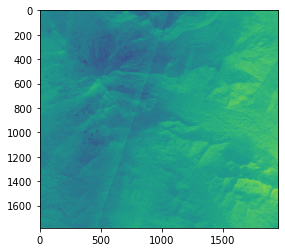

In [13]:
plt.imshow(shadow)

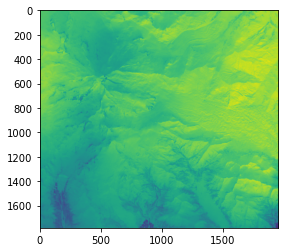

In [14]:
plt.imshow(albedo)

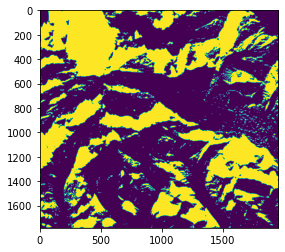

In [15]:
plt.imshow(shadow_artificial)

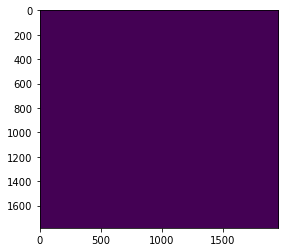

In [16]:
plt.imshow(cloud_mask)

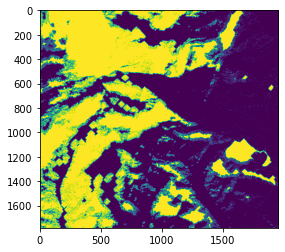

In [17]:
plt.imshow(classification)

In [18]:
item_dir, _ = os.path.split(item.get_self_href())

# save raster output files and upload them to storage
outputs = {
    "shadow": shadow.astype("float64"),
    "albedo": albedo.astype("float64"),
    "shadow_artificial": shadow_artificial,
    "classification": classification,
}
if cloud_mask is not None:
    outputs["cloud_mask"] = cloud_mask
    
for key, val in outputs.items():
    lpath = f"{work_path}/{key}.tif"
    rpath = f"{item_dir}/{key}.tif"
    no_dat = np.nan if val.dtype.kind == 'f' else -9999
    make_geo_im(val, transform, crs, lpath, no_dat=no_dat,
                meta_descr=input_parameters, date_created=date_created)
    stac2dcache.fs.put_file(lpath, rpath)
    item.add_asset(key, pystac.Asset(href=rpath))

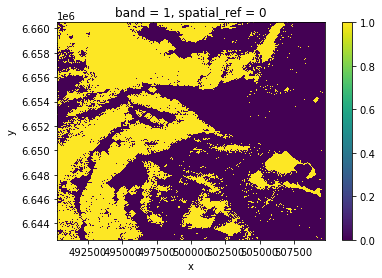

In [19]:
import rioxarray as rioxr
output_file = f"{work_path}/classification.tif"
da = rioxr.open_rasterio(output_file)
da.squeeze().plot.imshow()

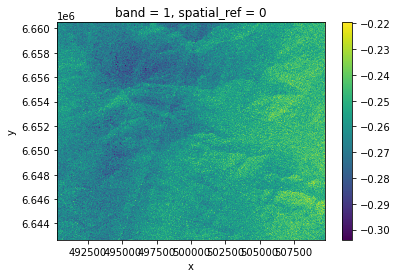

In [20]:
import rioxarray as rioxr
output_file = f"{work_path}/shadow.tif"
da = rioxr.open_rasterio(output_file)
da.squeeze().plot.imshow()

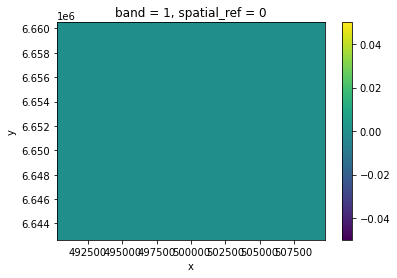

In [21]:
import rioxarray as rioxr
output_file = f"{work_path}/cloud_mask.tif"
da = rioxr.open_rasterio(output_file)
da.squeeze().plot.imshow()

In [22]:
# update item metadata
item.properties.update({
    "input_parameters": input_parameters
})

if cloud_mask is not None:
    # EO extension
    item_eo = EOExtension.ext(item, add_if_missing=True)
    item_eo.cloud_cover = cloud_mask.sum() / cloud_mask.size

# projection extension 
item_projection = ProjectionExtension.ext(item, add_if_missing=True)
item_projection.epsg = epsg

In [23]:
# update item
item.save_object()